# 고양이 수염 스티커 만들기!

## 목차
**1. 사진 준비하기**  

**2. 얼굴 준비하기**  (핵심!!)
  - 2-1. bounding box 추출하기  
  - 2-2. Face landmark (keypoint) 찾기  

**3. 스티커 씌우기**

**4. 다양한 변수 조사하기**

**5. 회고**  

## rubric 

|평가문항|상세기준|
|---|---|
|자기만의 카메라 기능 구현하기|원본에 스티커가 적절히 삽입되었다.|
|스티커 이미지를 정확한 원본 위치에 반영하기|정확한 좌표계산으로 수염의 위치가 잘 어울리게 출력되었다.|
|다양한 원본이미지에 적용했을 때 문제점 분석하기|얼굴각도, 이미지밝기, 촬영거리 등 다양한 변수에 따른 영향을 보고서에 체계적으로 분석하였다|

## Library

- os

불러올 이미지 경로를 설정해주기 위해 사용.  
- cv2

이미지를 불러와, 보고, 전처리하고, 저장할 때 사용.  
- matplotlib

이미지를 볼 때 사용(cv2 의 보조)  
- numpy

이미지데이터(배열)을 다루기 위해 사용  
- dlib
핵심기술인 bounding box 와 Face landmark 에 사용

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib


---


## 1. 사진 준비하기


(1080, 1440, 3)


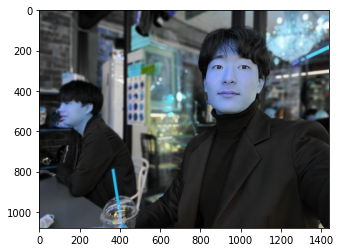

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/Study/Exp_3_camera/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
print(img_show.shape)
plt.imshow(img_bgr)
plt.show()

- openCV 는 defalut로 rgb 값이 아닌 bgr 값을 가져온다,  
파란색이 들어가야 할 곳에 빨강이, 빨강이 들어가야 할 곳에 파랑이 들어가버렸단 뜻.  
그러므로 cvtColor (convert Colot) 메서드를 이용해 색을 바꿔 사용한다.

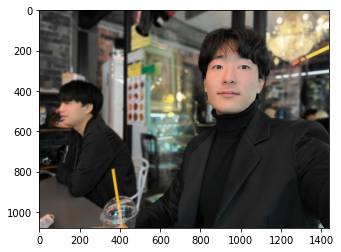

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 불러오기

### 2-1. Bounding Box 추출하기

rectangles[[(825, 231) (1092, 498)]]
좌 : 825, 위 : 231, 우 : 1092, 하 : 498


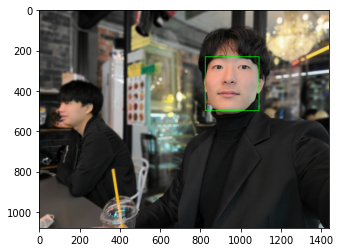

In [4]:
detector_hog = dlib.get_frontal_face_detector()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
print('좌 : {}, 위 : {}, 우 : {}, 하 : {}'.format(l, t, r, b))

cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 핵심 !!
- dlib 라이브러리에서 bounding box를 호춣하는 메서드를 사용해야 한다.  
face_detector 메서드를 사용해 내 얼굴을 감싸는 상자의 가로세로 좌표를 찾는다


- openCV 에서 rectangle 메서드를 이용해 원래 사진에 초록색 박스를 넣는다.  
0,255,0 은 박스의 색깔인 초록을 의미함


- 참고로 rectangle 객체를 하나씩 꺼낸 다음에는 (시퀀셜 상태일때는)  
위와 같이 left() bottom(), height(), width() 를 모두 불러올 수 있다.

In [5]:
for dlib_rect in dlib_rects:
    print('시퀀셜 상태일 때 : ',dlib_rect)
    print('가로 길이 : ', dlib_rect.width())
    print('세로 길이 : ', dlib_rect.height())

시퀀셜 상태일 때 :  [(825, 231) (1092, 498)]
가로 길이 :  268
세로 길이 :  268


### 2-2. Face landmark 찾기

얼굴의 ket-point 를 찾기 위해서는 다양한 얼굴 모델을 사용할 수 있는데,
우리가 사용하는 dlib 라이브러리에서는 

**ibug 300-W 데이터셋을 이용한 Pretrained model 을 사용한다.**  
무슨 프랑키 버전 6같은 느낌이라 좀 멋있다.  

regression tree의 앙상블 모델을 이용했다. 

해당 모델의 교육과정(?)은 이 논문에 실려있다.
[앙상블모델을 이용한 얼굴할당](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf)  

---
이 모델을 이용하기 위해선 따로 설치를 해야하는데,  
클라우드에 다음과 같은 코드를 넣어 b2z파일을 다운로드 후 사용하면 된다.  

'''   
1. wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2  
2. mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models  
3. cd ./'경로' && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2  

'''

In [6]:
model_path = os.getenv('HOME')+'/aiffel/Study/Exp_3_camera/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

- 다음과 같이 해당 학습모델을 경로로 shape_predictor() 메서드를 통해  
기술을 가져올 수 있다.

In [7]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print('내 얼굴에 찍힌 점은 총 :',len(list_landmarks[0]),'개')

내 얼굴에 찍힌 점은 총 : 68 개


여기가 내 코 끝이니까 여기다가 

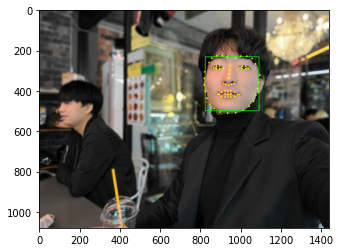

In [8]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 4, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

내 얼굴에 찍힌 68개의 점은 모두 일정한 index를 가지고 있다.  
논문에 따르면 그 순서는 다음과 같다.

<img src="./img/keypoint.PNG" width="500px" height="500px"></img>

## 3. 스티커 씌우기
### 3-1. 스티커 만들기

감사하게도 요즘 인터넷이 좋아서 왠만한 스티커는 다 무료 다운로드가 가능하다.
내 얼굴이랑 합쳐야 하니 배경이 투명한 PNG 파일을 다운로드 하자

[플래티콘 사이트](https://www.flaticon.com/kr/?&esl-k=google-ads%7cng%7cc549335758723%7cme%7ck%ED%94%8C%EB%9E%98%ED%8B%B0%20%EC%BD%98%7cp%7ct%7cdc%7ca121798090048%7cg12057876146&gclid=CjwKCAiAxJSPBhAoEiwAeO_fP1hVouP_ckyAAOa-v3ZO88I-b_9wkLkzGMAY1EphFORlxnsFHsKDHBoCy-oQAvD_BwE&gclsrc=aw.ds)

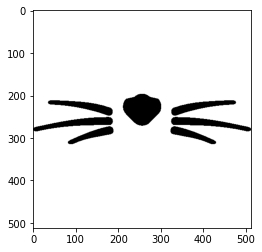

(512, 512, 3)


In [9]:
sticker_path = os.getenv('HOME')+'/aiffel/workplace/[E-03]/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
plt.imshow(img_sticker)
plt.show()

print(img_sticker.shape)


내가 가져온 고양이수염 사진.  
가로세로 512픽셀을 가지고 있다.

### 3-2. 스티커의 크기와 위치 정하기

- 난 고양이 수염은 큼직한 게 좋다. 
코 끝인 33번을 기준으로 한번 붙여보자

In [10]:
print('내 코 끝인 33번의 좌표는 : ',landmark[33])

내 코 끝인 33번의 좌표는 :  (941, 371)


In [11]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[33])
    x = landmark[33][0]
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x, y): (%d, %d)'%(x, y))
    print('(w, h): (%d, %d)'%(w, h))

(941, 371)
(x, y): (941, 371)
(w, h): (268, 268)


(x, y): (807, 237)


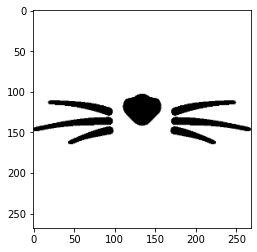

In [12]:
refined_x = x - w // 2
refined_y = y - w // 2
# 기준점이 사진의 맨 왼쪽 상단이므로 너비와 높이의 반만큼 이동해주어야 함

print('(x, y): (%d, %d)'%(refined_x, refined_y))

img_sticker = cv2.resize(img_sticker, (w,h))

plt.imshow(img_sticker)
plt.show()

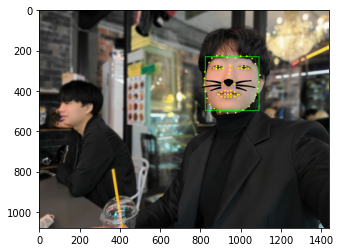

In [13]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)
#     np.where(img_sticker==0, img_sticker, sticker_area).astype(np.uint8)


plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

---
여기서 이제 라운딩 박스랑 키포인트 없애면 짜잔~


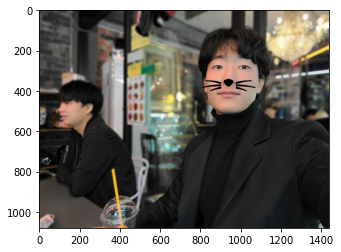

In [14]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

---
## 4. 다양한 변수 조사하기

### 생각해봐야할 사항

1. 얼굴 각도가 옆으로 돌아갈 때

2. 얼굴이 불분명할 때

3. 눈이 보이는 안경을 쓰고 있을 때

4. 눈이 보이지 않는 선글라스를 쓰고 있을 때

5. 촬영거리가 아주 멀 때

### 1. 얼굴 각도가 옆으로 돌아갈 때

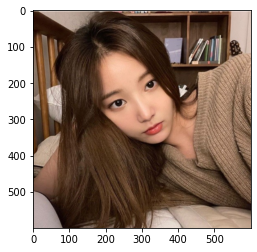

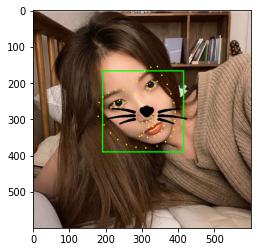

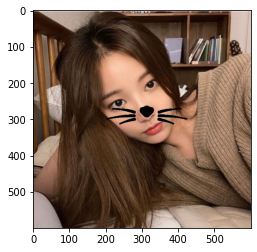

In [15]:
# 원본 이미지 불러오기
my_image_path = os.getenv("HOME") + '/aiffel/workplace/[E-03]/img/ywoo.PNG'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (600, 600))
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

# 이미지 위에 얼굴의 box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# landmark 모델 불러오기
model_path = os.getenv("HOME") + '/aiffel/Study/Exp_3_camera/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# 스티커 위치 및 크기 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    
# 스티커 이미지를 읽어와서 resize
sticker_path = os.getenv("HOME") + '/aiffel/workplace/[E-03]/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

# 이미지 시작점인 top-left 좌표로 x, y 좌표 변경
refined_x = x - w // 2
refined_y = y - w // 2

# 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- 화면이 돌아가면 이렇게 스티커 사진이 맞질 않는다,  
그래서 keypoint 를 이용해 얼굴의 각도를 추정해서  
그에 맞게 스티커를 회전해 줄 필요가 있다.

각도를 추정하기 위해선 math 라이브러리를 사용한다.

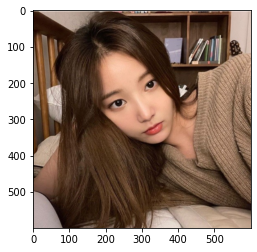

수정해야할 각도 :  30.323606862549987
(322, 303)
(x, y): (210, 191)
(w, h): (224, 224)


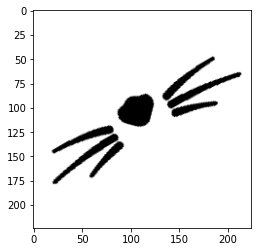

(x, y): (210, 191)


In [16]:
import math

my_image_path = os.getenv("HOME") + '/aiffel/workplace/[E-03]/img/ywoo.PNG'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (600, 600))
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

model_path = os.getenv("HOME") + '/aiffel/Study/Exp_3_camera/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

#바뀐 부분
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x_tilt = abs(landmark[42][0] - landmark[39][0])
    y_tilt = abs(landmark[42][1] - landmark[39][1])
    z_tilt = math.sqrt(x_tilt ** 2 + y_tilt ** 2)
    degree_tilt = math.degrees(math.acos(x_tilt / z_tilt))
    
    print('수정해야할 각도 : ', degree_tilt)

# 스티커 위치 및 크기 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[33])
    x = landmark[33][0] - dlib_rect.width() // 2
    y = landmark[33][1] - dlib_rect.width() // 2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x, y): (%d, %d)'%(x, y))
    print('(w, h): (%d, %d)'%(w, h))


sticker_path = os.getenv("HOME") + '/aiffel/workplace/[E-03]/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
center = w // 2
rows, cols = img_sticker.shape[:2]
tilt2 = cv2.getRotationMatrix2D((center,center), degree_tilt, 1)
img_sticker = cv2.warpAffine(img_sticker, tilt2, (cols, rows),borderValue=(255,255,255))

plt.imshow(img_sticker)
plt.show()

# 이미지 시작점인 top-left 좌표로 x, y 좌표 변경
refined_x = x 
refined_y = y 
print('(x, y): (%d, %d)'%(refined_x, refined_y))

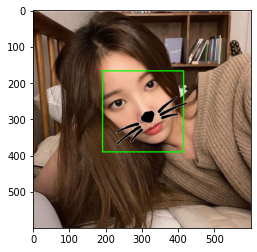

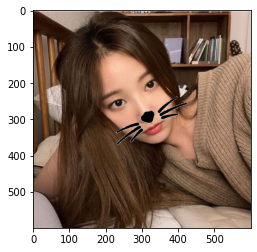

In [17]:
# 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 얼굴이 불분명할 때

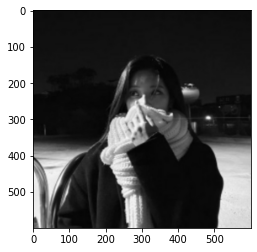

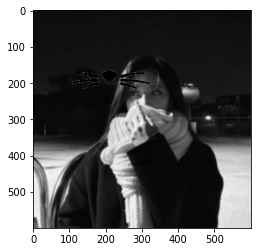

In [21]:
# 원본 이미지 불러오기
my_image_path = os.getenv("HOME") + '/aiffel/workplace/[E-03]/img/dark.PNG'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (600, 600))
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

# 이미지 위에 얼굴의 box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# landmark 모델 불러오기
model_path = os.getenv("HOME") + '/aiffel/Study/Exp_3_camera/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# 스티커 위치 및 크기 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    
# 스티커 이미지를 읽어와서 resize
sticker_path = os.getenv("HOME") + '/aiffel/workplace/[E-03]/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

# 이미지 시작점인 top-left 좌표로 x, y 좌표 변경
refined_x = x - w // 2
refined_y = y - w // 2

# 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


너무 어둡거나 얼굴을 일정부분 가린 사진은 dlib 라이브러리의 모델이 얼굴을 인지하지 못했다.


다양한 종류의 사진을 쉽게 구별해보고 싶어 
스티커를 씌우는 코드를 함수로 정의하고 여러 시도를 해 보았다.

- 스티커 코딩의 함수화

In [22]:

def camera_cute(img_path):

    # 원본 이미지 불러오기
    img_bgr = cv2.imread(img_path)
    img_bgr = cv2.resize(img_bgr, (600, 600))
    img_show = img_bgr.copy()
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

    detector_hog = dlib.get_frontal_face_detector()
    dlib_rects = detector_hog(img_rgb, 1)

    # 이미지 위에 얼굴의 box 출력
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

    # landmark 모델 불러오기
    model_path = os.getenv("HOME") + '/aiffel/Study/Exp_3_camera/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)

    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    for landmark in list_landmarks:
        for idx, point in enumerate(list_points):
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)

    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

    # 스티커 위치 및 크기 계산
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[30][0]
        y = landmark[30][1]
        w = dlib_rect.width()
        h = dlib_rect.width()

    # 스티커 이미지를 읽어와서 resize
    sticker_path = os.getenv("HOME") + '/aiffel/workplace/[E-03]/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w, h))

    # 이미지 시작점인 top-left 좌표로 x, y 좌표 변경
    refined_x = x - w // 2
    refined_y = y - w // 2

    # 스티커 적용
    sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 결과 이미지 출력
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    return plt.show()

## 3. 안경을 쓰고 있을 때

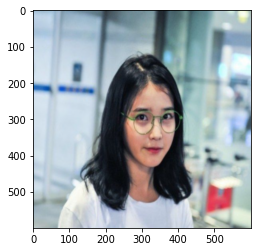

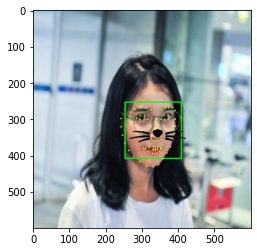

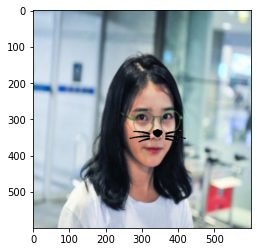

In [23]:
iu_path = os.getenv("HOME") + '/aiffel/workplace/[E-03]/img/iu.PNG'

camera_cute(iu_path)

## 4. 선글라스를 썼을 때

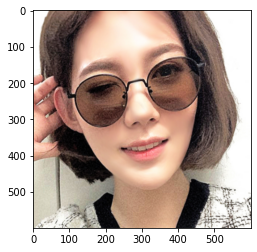

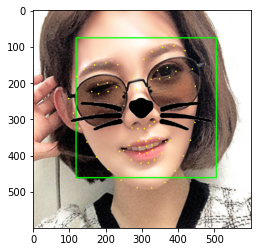

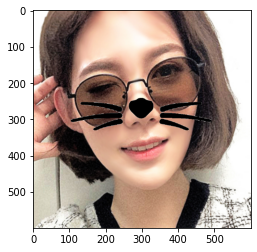

In [28]:
taeyeon_path = os.getenv("HOME") + '/aiffel/workplace/[E-03]/img/idk.PNG'

camera_cute(taeyeon_path)

## 5. 아주 멀리 있을 때

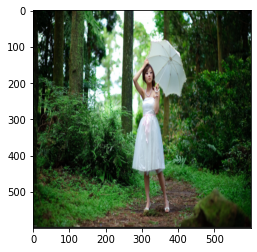

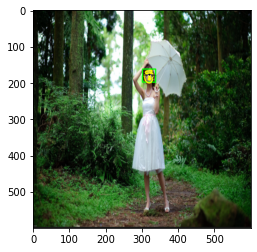

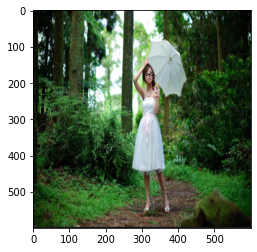

In [29]:
taeyeon_path = os.getenv("HOME") + '/aiffel/workplace/[E-03]/img/far.PNG'

camera_cute(taeyeon_path)

## 결과 :

멀리 있거나 안경을 쓰고 있는 부분까지는 landmark 인식이 되었지만,  
얼굴이 너무 불분명하거나 인식이 어려우면 landmark 인식을 하지 못한다.  

나는 이것이 ibug 300-W 데이터셋을 이용한 Pretrained model이  
얼굴각도 ,안경의 유무, 촬영거리 까지는 학습을 마쳤지만 얼굴을 가린 사람, 어두운 밝기의 사람은  
학습하지 못했을 것이라고 추측한다.  

## 5. 회고 

### 소감
" 🙄 아니 이게 이렇게 된다고? 아니 이게 요걸로 된다고?.. 점점 늘어가는 파이썬 라이브러리를 향한 경외심,,"  
  
openCV 에 대해 많이 알게 된 프로젝트였습니다.  
코드를 작성하면서 본의 아니게 이미지 경로 설정에 대한 실력(?)이 늘었습니다.    
한번 가져온 이미지를 openCV 라이브러리로 요리 자르고 저리 바꾸고 하면서 화가의 기분을 느꼈습니다.   
(이정도 기술은 그러니까 앱스토어에 지천으로 깔렸다는거지..?)  
 
### 어려웠던 점

**1. 사진파일의 좌표 기준점**  
**2. PNG 파일의 채널 수 고려**  

처음에 이 두가지를 고려하지 않고 실행했을 때는 다음과 같았다.

<img src="./img/error.PNG"></img>

좌표기준점을 단순히 코에 맞추니 저렇게 수염 사진의 왼쪽 위가 기준이 되어 맞춰졌다.

또한 배경이 투명하지 않고 하얀색으로 노출되었다.  

---

때문에 좌표는 사진파일의 너비와 높이를 기준으로 절반씩 절감해주었다.

In [18]:
refined_x = x - w // 2
refined_y = y - w // 2

그리고 사진파일을 불러올 때 사용하는 np.where() 메서드의 값을 255로 변경해주니 바깥의 하얀 색을 없앨 수 있었다.

**3. 스티커 회전**  

-1. 각도방향 문제  
사람이 왼쪽으로 고개를 꺾는지 오른쪽으로 꺾는지에 따라 각도 계산을 할때 차이가 있었다.

각도는 조절할 수 있지만 그 방향은 제곱이 씌워지면서 계산 시에 사라지기 때문이다.  
그래서 처음에 왼쪽눈, 오른쪽 눈 중 어느 것의 y값이 더 큰지를 계산하고   
각도를 어느 쪽으로 틀어줄 지 결정하는 코드를 넣으면 더 좋은 개선이 될 것 같다.  

-2. 이미지 손실 문제  
스티커를 회전함에 따라 수염이 잘리고 는 현상이 일어났다.     
때문에 스티커가 잘리지 않도록 중심점에서 수염만 돌리는 방법이 필요했다.    

그래서   
getRotationMatrix2D()  
warpAffine()  
메소드를 찾아 사용했다, 로테이션 매트릭스로 변환할 각도 행렬을 만들어준다음    
warpAffine() 메서드로 사진을 회전시켰다.  

<img src="./img/error2.PNG"></img>

다만 저렇게 회전하고 남은 공간에 0,0,0의 검정 이미지가 들어갔는데, 이것을   
borderValue=(255,255,255) 라는 키워드 인자 수정을 통해 해결할 수 있었다.

### 진행하면서 알아낸 점

OpenCV 의 놀라운 범용성을 느꼈다. openCV에서는   
사진 확대부터 조절, 회전, 잘라넣기-붙여넣기 등 다양한 기능을 지원하고 있다.    
솔직히 프로젝트를 진행하며 내가 라이브러리에 대해 너무 모른다는 생각도 많이 들었다.  

파이썬을 잘 한다는 것은 라이브러리를 잘 쓴다는 문장이 과언이 아니다,,  
물론 우리가 사용하는 모델의 이론이나 이해도 중요하지만,  
존재하는 알고리즘과 모델을 200% 사용할 수 있는 메서드의 통달도    

내가 성장하기 위한 꼭 필요한 과정이다.  
앞으로 알고리즘과 라이브러리 이해 모두 놓치지 않고 두마리 토끼를 잡고 말겠다!!  